 # MLP CIFAR100

In [2]:
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.autograd import Variable
import torchvision.datasets as td
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from torch.utils.data import TensorDataset

from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
from sklearn.utils.fixes import signature

from scipy.special import entr

cuda = torch.cuda.is_available()
print('Using PyTorch version:', torch.__version__, 'CUDA:', cuda)

Using PyTorch version: 0.4.1.post2 CUDA: False


In [3]:
batch_size = 32

kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}

train_loader = torch.utils.data.DataLoader(
    datasets.CIFAR100('./data', train=True, download=True,
                     transform=transforms.Compose([
                         transforms.ToTensor(),
                         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                     ])),
    batch_size=batch_size, shuffle=True, **kwargs)

test_loader = torch.utils.data.DataLoader(
    datasets.CIFAR100('./data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                   ])),
    batch_size=batch_size, shuffle=False, **kwargs)

Files already downloaded and verified


Verifico il corretto funzionamento del dataset:

In [4]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

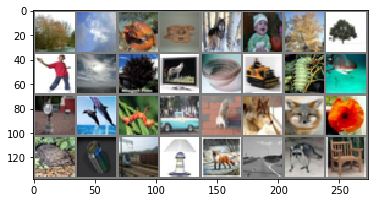

In [5]:
dataiter = iter(train_loader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))

Uso l'80% del dataset per l'addestramento della rete, il restante 20% lo uso per fare test OOD

In [6]:
split = int(np.floor(len(train_loader.dataset.train_labels))*0.8)

train_l = train_loader.dataset.train_labels[0:split]
train_l = torch.IntTensor(train_l)

train_d = train_loader.dataset.train_data[0:split]
train_d = torch.FloatTensor(train_d)


val_l = train_loader.dataset.train_labels[split:-1]
val_l = torch.IntTensor(val_l)

val_d = train_loader.dataset.train_data[split:-1]
val_d = torch.FloatTensor(val_d)


test_lID = test_loader.dataset.test_labels
test_lID = torch.IntTensor(test_lID)

test_dID = test_loader.dataset.test_data
test_dID = torch.FloatTensor(test_dID)


test_lOD = test_loader.dataset.test_labels
test_lOD = torch.IntTensor(test_lOD)

test_dOD = test_loader.dataset.test_data
test_dOD = torch.FloatTensor(test_dOD)

In [7]:
train_d[0]

tensor([[[255., 255., 255.],
         [255., 255., 255.],
         [255., 255., 255.],
         ...,
         [195., 205., 193.],
         [212., 224., 204.],
         [182., 194., 167.]],

        [[255., 255., 255.],
         [254., 254., 254.],
         [254., 254., 254.],
         ...,
         [170., 176., 150.],
         [161., 168., 130.],
         [146., 154., 113.]],

        [[255., 255., 255.],
         [254., 254., 254.],
         [255., 255., 255.],
         ...,
         [189., 199., 169.],
         [166., 178., 130.],
         [121., 133.,  87.]],

        ...,

        [[148., 185.,  79.],
         [142., 182.,  57.],
         [140., 179.,  60.],
         ...,
         [ 30.,  17.,   1.],
         [ 65.,  62.,  15.],
         [ 76.,  77.,  20.]],

        [[122., 157.,  66.],
         [120., 155.,  58.],
         [126., 160.,  71.],
         ...,
         [ 22.,  16.,   3.],
         [ 97., 112.,  56.],
         [141., 161.,  87.]],

        [[ 87., 122.,  41.],
       

Creo una funzione che mi separa i dataset e mette le etichette adeguate:

In [8]:
def createData(label, data, dim):
    zeros_d = data[label == 0]
    zeros_l = torch.zeros((len(zeros_d),))
    for i in (1, dim):
        nameNum_i = data[label == i]
        zeros_d = torch.cat([zeros_d, nameNum_i])
        if i == 1:
            zeros_l = torch.cat([zeros_l, torch.ones((len(nameNum_i),))])
        if i > 1:
            zeros_l = torch.cat([zeros_l, i*torch.ones((len(nameNum_i),))])
    zeros_d = zeros_d.type(torch.float32)
    return zeros_d.permute(0, 3, 1, 2) / 255.0, zeros_l

In [9]:
## Per il restante 20% serve far ripartire da zero le etichette quindi faccio una funzione adeguata
def createData20(label, data):
    eighty_d = data[label == 80]
    eighty_l = torch.zeros((len(eighty_d),))
    for i in (81, 99):
        nameNum_i = data[label == i]
        eighty_d = torch.cat([eighty_d, nameNum_i])
        tmp = i-80
        if tmp == 1:
            eighty_l = torch.cat([eighty_l, torch.ones((len(nameNum_i),))])
        if tmp > 1:
            eighty_l = torch.cat([eighty_l, i*torch.ones((len(nameNum_i),))])
    eighty_d = eighty_d.type(torch.float32)
    return eighty_d.permute(0, 3, 1, 2) / 255.0, eighty_l

In [10]:
#train loader da 0 a 79 80%
train_data, train_labels = createData(train_l, train_d, 79)
train_ds079 = TensorDataset(train_data, train_labels)
train_loader079 = torch.utils.data.DataLoader(train_ds079, batch_size=batch_size, shuffle=True, **kwargs)

print(len(train_loader079))

#validation loader da 0 a 79 20%
val_data, val_labels = createData(val_l, val_d, 79)
val_ds079 = TensorDataset(val_data, val_labels)
val_loader079 = torch.utils.data.DataLoader(val_ds079, batch_size=batch_size, shuffle=True, **kwargs)

print(len(val_loader079))

#test loaderOD da 80 a 99
testID_data, testID_labels = createData(test_lID, test_dID, 79)
test_dsID = TensorDataset(testID_data, testID_labels)
test_loaderID = torch.utils.data.DataLoader(test_dsID, batch_size=batch_size, shuffle=True, **kwargs)

print(len(test_loaderID))

#test loaderOD da 80 a 99
testOD_data, testOD_labels = createData20(test_lOD, test_dOD)
test_dsOD = TensorDataset(testOD_data, testOD_labels)
test_loaderOD = torch.utils.data.DataLoader(test_dsOD, batch_size=batch_size, shuffle=True, **kwargs)

print(len(test_loaderOD))

37
11
10
10


In [11]:
foo = iter(train_loader079).next()
foo[0].max()

tensor(1.)

## Multi-layer Perceptron

In [12]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 5)
        self.fc1 = nn.Linear(64 * 5 * 5, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 100)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        z = self.fc3(x)
        x = F.log_softmax(z, 1)
        return (x, z)


'''class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(32*32*3, 128)
        self.fc1_drop = nn.Dropout(0.2)
        self.fc2 = nn.Linear(128, 128)
        self.fc2_drop = nn.Dropout(0.2)
        self.fc3 = nn.Linear(128, 100)     # Numero di output 100

    def forward(self, x):
        x = x.view(-1, 32*32*3)
        x = F.relu(self.fc1(x))
        x = self.fc1_drop(x)
        x = F.relu(self.fc2(x))
        x = self.fc2_drop(x)
        return F.log_softmax(self.fc3(x), 1)
'''

model = Net()
if cuda:
    model.cuda()
    
optimizer = optim.Adam(model.parameters(), lr=0.001)
print(model)


Net(
  (conv1): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=1600, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=100, bias=True)
)


In [13]:
def train(epoch, log_interval, loader):
    model.train()
    batch_idx = 0
    while(batch_idx != len(loader)):
        for (data, target) in loader:
            target = target.type(torch.long)
            if cuda:
                data, target = data.cuda(), target.cuda()
            data, target = Variable(data), Variable(target)
            optimizer.zero_grad()
            (output, _) = model(data)
            loss = F.nll_loss(output, target)
            loss.backward()
            optimizer.step()
            if batch_idx % log_interval == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_idx * len(data), len(loader.dataset),
                    100. * batch_idx / len(loader), loss.item()), end='\r')
            batch_idx = batch_idx + 1

In [14]:
def validate(loss_vector, accuracy_vector, loader):
    model.eval()
    val_loss, correct = 0, 0
    for data, target in loader:
        target = target.type(torch.long)
        if cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        (output, _) = model(data)
        val_loss += F.nll_loss(output, target).item()
        pred = output.data.max(1)[1] # get the index of the max log-probability
        correct += pred.eq(target.data).cpu().sum()

    val_loss /= len(loader)
    loss_vector.append(val_loss)

    accuracy = 100. * correct / len(loader.dataset)
    accuracy_vector.append(accuracy)
    
    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        val_loss, correct, len(loader.dataset), accuracy))

In [15]:
## Addestramento della rete su dataset0-79 con 3 epoche
epochs = 50

lossv, accv = [], []
for epoch in range(1, epochs + 1):
    train(epoch, 1, train_loader079)
    validate(lossv, accv, test_loaderID)

Train Epoch: 1 [936/1178 (97%)]	Loss: 1.2938576
Validation set: Average loss: 1.1806, Accuracy: 100/300 (33%)

Train Epoch: 2 [936/1178 (97%)]	Loss: 0.8779536
Validation set: Average loss: 0.9321, Accuracy: 186/300 (62%)

Train Epoch: 3 [936/1178 (97%)]	Loss: 0.8065262
Validation set: Average loss: 0.7078, Accuracy: 208/300 (69%)

Train Epoch: 4 [936/1178 (97%)]	Loss: 0.6916263
Validation set: Average loss: 0.6472, Accuracy: 205/300 (68%)

Train Epoch: 5 [936/1178 (97%)]	Loss: 0.5902964
Validation set: Average loss: 0.5074, Accuracy: 241/300 (80%)

Train Epoch: 6 [936/1178 (97%)]	Loss: 0.9049634
Validation set: Average loss: 0.4546, Accuracy: 242/300 (80%)

Train Epoch: 7 [936/1178 (97%)]	Loss: 0.3807007
Validation set: Average loss: 0.4470, Accuracy: 247/300 (82%)

Train Epoch: 8 [936/1178 (97%)]	Loss: 0.8043384
Validation set: Average loss: 0.3988, Accuracy: 252/300 (84%)

Train Epoch: 9 [936/1178 (97%)]	Loss: 0.4224662
Validation set: Average loss: 0.3967, Accuracy: 259/300 (86%)

T

In [16]:
def max_test(epoch, loader):
    model.eval ()
    test_loss = 0
    correct = 0
    preds_list = []
    for data, target in loader:
        target = target.type(torch.long)
        if cuda:
            data, target = data.cuda(), target.cuda()
        data = Variable(data)
        target = Variable(target)
        (output, _) = model(data)
        preds_list.append(output)
        test_loss += F.nll_loss (output, target).item ()  # sum up batch loss
        pred = output.max (1, keepdim=True)[1]  # get the index of the max log-probability
        correct += pred.eq (target.view_as (pred)).sum ().item ()
    max_pred = new_predict(preds_list)
    test_loss /= len (loader.dataset)
    print ('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format (
        test_loss, correct, len (loader.dataset),
        100. * correct / len (loader.dataset)))
    return max_pred

In [17]:
###### rifaccio funzione predict che prende gli output di test li mette in numpy come matrice
def new_predict(preds_list):
    preds_list = torch.cat(preds_list)
    preds_list = torch.exp(preds_list)
    preds_list = preds_list.detach()
    preds_list = preds_list.numpy()
    preds_list = np.matrix(preds_list)
    print('\nLe probabilità di classificazione sono: ')
    print(preds_list)
    print('')
    idness = np.max(preds_list, 1)
    #print ('\nLa max probabilità è: ')
    #print(idness)
    return idness

In [18]:
def plot_func(y_true, y_scores, AP):
    precision, recall, _ = precision_recall_curve(y_true, y_scores)

    # In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
    step_kwargs = ({'step': 'post'}
                   if 'step' in signature(plt.fill_between).parameters
                   else {})
    plt.step(recall, precision, color='b', alpha=0.2,
             where='post')
    plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    
    return plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(AP))

In [19]:
def experiment_func(choosing_test):
    test = choosing_test
    ## Test_loader012
    print('\nTEST DATASET 012')
    result_ID = test(epoch, test_loaderID)
    len_ID = len(result_ID)

    resID = np.empty((0, len_ID))
    for i in range (0, len_ID):
        newvalue = result_ID[i]
        resID = np.append(resID, newvalue)

    ## Test_loader345
    print('\nTEST DATASET 345')
    result_OOD = test(epoch, test_loaderOD)
    len_OOD = len(result_OOD)

    resOOD = np.empty((0, len_OOD))
    for i in range (0, len_OOD):
        newvalue = result_OOD[i]
        resOOD = np.append(resOOD, newvalue) 

    ## Raccolgo le predizioni max o con entropia in y_scores
    y_scores =np.concatenate((resID, resOOD), axis = None)

    pred_ID = np.ones(len_ID, dtype=int)
    pred_OOD = np.zeros(len_OOD, dtype=int)

    ## Raccolgo le etichette, agli inD assegno 1, agli outD assegno 0
    y_true = np.concatenate((pred_ID, pred_OOD), axis = None)

    AP = average_precision_score(y_true, y_scores)

    print('L Avarage Precision è: ', AP)

    plot_func(y_true, y_scores, AP)
    
    return AP


TEST DATASET 012

Le probabilità di classificazione sono: 
[[1.00000000e+00 4.52284922e-07 3.93361637e-17 ... 8.51610949e-16
  2.22464680e-16 2.15237213e-16]
 [1.00000000e+00 6.26632010e-16 3.55759392e-31 ... 5.11046775e-29
  6.55268699e-30 7.32099010e-30]
 [1.52366542e-09 2.79977314e-07 1.80789758e-12 ... 1.13130165e-12
  1.26817629e-14 1.48256346e-14]
 ...
 [8.08887819e-08 9.83344393e-08 1.24135468e-12 ... 1.10646388e-12
  2.06566653e-14 3.44172221e-14]
 [2.57731244e-05 5.03627956e-03 7.83110122e-12 ... 8.76723954e-12
  1.55779103e-13 1.84487679e-13]
 [1.00000000e+00 7.07339268e-16 1.22953438e-28 ... 1.90569366e-26
  3.53901645e-27 1.28555716e-26]]


Test set: Average loss: 0.0153, Accuracy: 273/300 (91%)


TEST DATASET 345

Le probabilità di classificazione sono: 
[[7.0203278e-05 1.8505883e-05 1.4828647e-12 ... 2.6292165e-12
  6.0241871e-14 1.3462877e-13]
 [1.6655710e-03 2.5029544e-04 4.3251205e-10 ... 7.3475453e-10
  4.2914602e-11 7.8641101e-11]
 [1.6987151e-09 2.3671589e-15 1.796

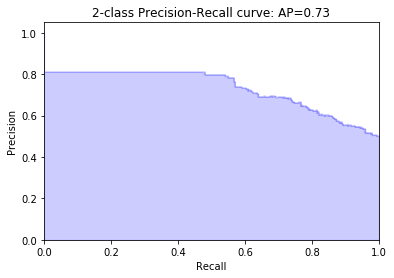

In [20]:
max_AP = experiment_func(max_test)

In [25]:
def en_test(epoch, loader):
    model.eval ()
    test_loss = 0
    correct = 0
    preds_list = []
    for data, target in loader:
        target = target.type(torch.long)
        if cuda:
            data, target = data.cuda(), target.cuda()
        data = Variable(data)
        target = Variable(target)
        (output, _) = model(data)
        preds_list.append(output)
        test_loss += F.nll_loss (output, target).item ()  # sum up batch loss
        pred = output.max (1, keepdim=True)[1]  # get the index of the max log-probability
        correct += pred.eq (target.view_as (pred)).sum ().item ()
    ent_pred = predict_entropy(preds_list)
    test_loss /= len (loader.dataset)
    print ('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format (
        test_loss, correct, len (loader.dataset),
        100. * correct / len (loader.dataset)))
    return ent_pred

In [26]:
def predict_entropy(preds_list):
    preds_list = torch.cat(preds_list)
    preds_list = torch.exp(preds_list)
    preds_list = preds_list.detach()
    preds_list = preds_list.numpy()
    preds_list = np.matrix(preds_list)
    print('\nLe probabilità di classificazione sono: ')
    print(preds_list)
    print('')
    entropy = (-entr(preds_list)).sum(1)
    #print('\nL entropia di ciascuna tripletta è: ')
    #print(entropy)
    return entropy


TEST DATASET 012

Le probabilità di classificazione sono: 
[[9.9991226e-01 8.7236760e-05 2.7849940e-16 ... 3.2409581e-15
  9.4385644e-16 7.9986189e-16]
 [2.3694295e-07 2.0034415e-07 1.8029156e-11 ... 1.8408575e-11
  4.4620248e-13 7.8799125e-13]
 [9.9617833e-01 3.8148467e-03 1.4410703e-13 ... 1.4891797e-12
  3.4793395e-13 2.3903140e-13]
 ...
 [9.9999809e-01 2.0082343e-06 4.3098655e-23 ... 2.3036447e-21
  3.7912337e-22 1.4762987e-22]
 [9.9888009e-01 5.3225272e-06 5.1019141e-15 ... 3.6825330e-14
  4.1983374e-15 8.1119168e-15]
 [2.2006148e-18 1.0000000e+00 1.3133581e-29 ... 4.4044904e-29
  1.3574789e-31 1.4473333e-33]]


Test set: Average loss: 0.0150, Accuracy: 273/300 (91%)


TEST DATASET 345

Le probabilità di classificazione sono: 
[[4.5320699e-06 1.8122767e-03 2.3828338e-14 ... 4.1619509e-14
  3.3800008e-16 3.5586252e-16]
 [5.3676169e-05 9.9866480e-01 9.5805969e-13 ... 2.4242598e-12
  9.6191908e-14 4.0907104e-14]
 [9.3427871e-06 2.6496373e-05 6.3152013e-09 ... 5.8282983e-09
  3.97036

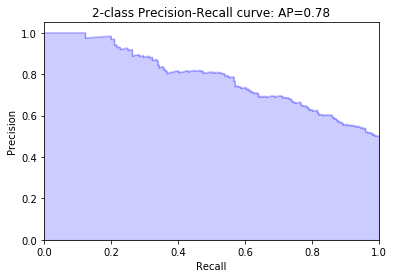

In [27]:
en_AP = experiment_func(en_test)

In [24]:
print('La differenza tra en_AP e max_AP è: ', en_AP - max_AP)

La differenza tra en_AP e max_AP è:  0.05142644517076522
